# Audio Denoising Using Autoencoders


Denoising Autoencoders (DAEs) are a type of artificial neural network designed to learn representations of data by reconstructing the original inputs from noisy or corrupted versions. They belong to the broader family of autoencoders, which are unsupervised learning models that learn to encode and decode data in a way that minimizes the difference between the input and the reconstructed output. DAEs have gained significant attention in the field of machine learning and deep learning due to their ability to efficiently capture the underlying structure of data while being robust to noise and corruption.

The architecture of a denoising autoencoder consists of two main components: an encoder and a decoder. The encoder is responsible for transforming the noisy input data into a lower-dimensional latent representation or code. The decoder then takes this latent representation and reconstructs the original data, ideally removing the noise introduced during the encoding process.

Applications of Denoising Autoencoders:

1. Image denoising: DAEs have been successfully used to remove noise from images, improving their quality and making them suitable for further processing or analysis. This is especially useful in fields like medical imaging, where high-quality images are critical for accurate diagnosis.

2. Feature extraction: DAEs can be used to learn meaningful and robust features from data, which can then be used as input for other machine learning tasks such as classification, clustering, or regression.

3. Dimensionality reduction: DAEs can be employed to reduce the dimensionality of high-dimensional data, making it easier to visualize, analyze, and process. This can help mitigate the "curse of dimensionality" and improve the performance of machine learning algorithms.

4. Anomaly detection: DAEs can be used to identify unusual patterns or outliers in data, as the reconstruction error will be higher for anomalies compared to typical data points. This has applications in fraud detection, network security, and quality control.

5. Data imputation: DAEs can be used to fill in missing or corrupted values in datasets, thereby improving the quality of the data and enabling more accurate analysis and prediction.

6. Pretraining: DAEs can be employed as a pretraining mechanism for other deep learning models, such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs). By initializing the weights of these models with the learned features of a DAE, they can converge faster and achieve better performance.

I want to explore denoising autoencoder's ability to denoise audio input.

In [1]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
import pickle

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

First we need a function to transform audio signal into tensor that PyTorch can process.

In [5]:
def signal_to_tensor(x):
    out = np.expand_dims(x, axis=0)
    if len(x.shape) == 1:
        out = np.expand_dims(out, axis=0)
    out = torch.from_numpy(out)
    out = out.type(torch.Tensor)
    out = out.permute(1, 0, 2)
    return out

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=32,
            kernel_size=2048,
            stride=32,
            padding=1023,
            bias=True
        )

        self.synconv1 = nn.ConvTranspose1d(
            in_channels=32,
            out_channels=1,
            kernel_size=2048,
            stride=32,
            padding=1023,
            bias=True
        )

    def encoder(self, x):
        x = self.conv1(x)
        return torch.tanh(x)

    def decoder(self, y):
        return self.synconv1(y)

    def forward(self, x):
        y = self.encoder(x)
        return self.decoder(y)

In [17]:
batch = 1
audio, sample_rate, = librosa.load('./sample.wav', mono=False, sr=None, offset=6)
audio[0,:] /= np.abs(audio[0,:]).max()
audio[1,:] /= np.abs(audio[1,:]).max()
X_train = (signal_to_tensor(audio[0,:]) + + torch.randn(X_train.size()) * 0.05).to(device)
X_test = signal_to_tensor(audio[1,:]).to(device)

In [18]:
print("Generate Model:")
model = Autoencoder().to(device)
print('Total number of parameters:', (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("\nLoss function:")
loss_fn = nn.MSELoss()

Ypred = model(X_train)
   
outputlen = len(Ypred[0,0,:])
print("output_len =", outputlen)
    
Y = X_train[:,:,:outputlen]
    
print("Input X.shape =", X_train.shape )
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Generate Model:
Total number of parameters: 131105

Loss function:
output_len = 11934690
Input X.shape = torch.Size([1, 1, 11934720])
Target Y.shape = torch.Size([1, 1, 11934690])
Target Y = tensor([[[ 0.0319, -0.0100,  0.0067,  ..., -0.0126,  0.0162, -0.0599]]],
       device='cuda:0')
Y.type() = torch.cuda.FloatTensor


In [20]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Y_pred = model(X_train)
print("Y_pred =", Y_pred)

# True for optimization of random direction, False for pytorch optimization
randdir = False
    
if randdir == True:
    # optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(
        model,
        loss_fn,
        X_train,
        Y,
        iterations=100000,
        startingscale=0.25,
        endscale=0.0
    )
else:
    for epoch in range(4000):
        # distortions: shift and noise:
        Xlast = X_train[:,:,-1].clone() 
        X_train[:,:,1:] = X_train[:,:,:-1].clone() # round Robbin, shift 1 right
        X_train[:,:,0] = Xlast.clone()
        Ylast = Y[:,:,-1].clone() 
        Y[:,:,1:] = Y[:,:,:-1].clone() # round Robbin, shift 1 right
        Y[:,:,0] = Ylast.clone()

        Ypred = model(X_train)
        loss = loss_fn(Ypred, Y)
        if epoch % 10 == 0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Y_pred = tensor([[[-0.0207, -0.0137, -0.0227,  ..., -0.0110, -0.0275,  0.0065]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)
0 0.03561048209667206
10 0.026463046669960022
20 0.021252507343888283
30 0.018065787851810455
40 0.015499431639909744
50 0.013436129316687584
60 0.01169869676232338
70 0.010234754532575607
80 0.009001639671623707
90 0.00798327848315239
100 0.007166188210248947
110 0.006501669529825449
120 0.005967964418232441
130 0.005536740645766258
140 0.00518391327932477
150 0.0048928027972579
160 0.004646715242415667
170 0.004434413276612759
180 0.0042555020190775394
190 0.0040961261838674545
200 0.003955811727792025
210 0.0038297995924949646
220 0.003716424573212862
230 0.0036112710367888212
240 0.0035157857928425074
250 0.0034249690361320972
260 0.0033420000690966845
270 0.00326350424438715
280 0.0031897155568003654
290 0.0031194838229566813
300 0.0030535853002220392
310 0.0029890609439462423
320 0.0029289317317306995
330 0.002869205316528678
340 0.002812361344

3040 5.306982347974554e-05
3050 5.182927634450607e-05
3060 5.0817227020161226e-05
3070 4.9894839321495965e-05
3080 4.886571332463063e-05
3090 4.78734182252083e-05
3100 4.722706580650993e-05
3110 4.5868375309510157e-05
3120 4.5031512854620814e-05
3130 4.399488170747645e-05
3140 4.313085810281336e-05
3150 4.233764411765151e-05
3160 4.145746061112732e-05
3170 4.0863571484806016e-05
3180 3.973747880081646e-05
3190 3.886838021571748e-05
3200 3.818239929387346e-05
3210 3.731169999809936e-05
3220 3.657759589259513e-05
3230 3.5971035686088726e-05
3240 3.5312627005623654e-05
3250 3.441362059675157e-05
3260 3.369833211763762e-05
3270 3.321616895846091e-05
3280 3.264249244239181e-05
3290 3.1689240131527185e-05
3300 3.107531665591523e-05
3310 3.054592161788605e-05
3320 2.9897555577917956e-05
3330 2.9500768505386077e-05
3340 2.8720005502691492e-05
3350 2.816094274749048e-05
3360 2.7641472115647048e-05
3370 2.713087815209292e-05
3380 2.7703526939149015e-05
3390 2.643613152031321e-05
3400 2.564361966

ww= OrderedDict([('conv1.weight', tensor([[[ 0.0102,  0.0040, -0.0005,  ...,  0.0059,  0.0186, -0.0115]],

        [[ 0.0006,  0.0109, -0.0033,  ...,  0.0024,  0.0135, -0.0051]],

        [[ 0.0071,  0.0107,  0.0052,  ..., -0.0044,  0.0090, -0.0102]],

        ...,

        [[ 0.0074, -0.0069, -0.0112,  ...,  0.0137, -0.0091,  0.0132]],

        [[ 0.0069, -0.0089, -0.0022,  ..., -0.0193,  0.0199, -0.0075]],

        [[ 0.0148, -0.0035,  0.0010,  ...,  0.0182, -0.0001, -0.0080]]])), ('conv1.bias', tensor([-0.0127,  0.0025, -0.0105,  0.0114, -0.0003, -0.0096,  0.0019, -0.0163,
         0.0216, -0.0114, -0.0073,  0.0058, -0.0119,  0.0039,  0.0060, -0.0019,
        -0.0077,  0.0209, -0.0018, -0.0024,  0.0025, -0.0065, -0.0044,  0.0029,
         0.0032,  0.0031,  0.0020,  0.0064, -0.0037, -0.0021,  0.0076,  0.0092])), ('synconv1.weight', tensor([[[ 0.0193,  0.0076,  0.0051,  ...,  0.0098,  0.0232, -0.0067]],

        [[ 0.0036,  0.0144, -0.0011,  ...,  0.0090,  0.0191,  0.0043]],

        

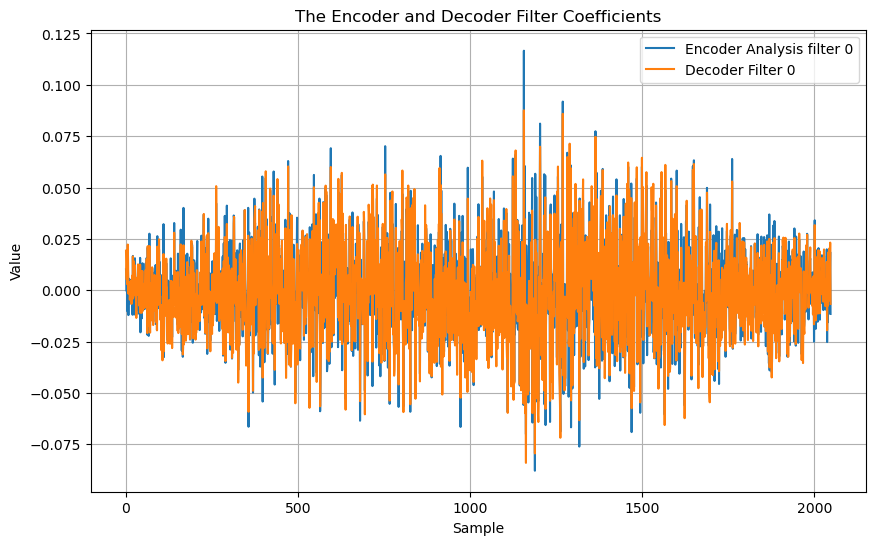

In [26]:
ww = model.cpu().state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()